In [1]:
import pandas as pd
import pathlib
from keras.layers import LSTM, Dense
from keras.models import Sequential
import datetime
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import MinMaxScaler

2021-10-24 11:16:09.272373: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64:
2021-10-24 11:16:09.272436: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
PROCESSED_DIR = pathlib.Path("../data/processed/")
relevant_entries = ["Bad", "West", "Lene", "Stadion"]

In [3]:
analysis_df = pd.DataFrame()
for time_series_df_path in PROCESSED_DIR.glob("*.csv"):
    if "Bad" in str(time_series_df_path):
        df = pd.read_csv(time_series_df_path)
        analysis_df = analysis_df.append(df)

In [4]:
train_df = analysis_df
test_df = pd.read_csv(PROCESSED_DIR / "Lene_202110222140_scanExport_6027.csv")

In [5]:
def preprocess_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df.rename(columns={"Date":"ds", "CountOfPersons":"y"})
    df["ds"] = pd.to_datetime(df.ds)
    return df

In [6]:
train_df = preprocess_df(train_df)
test_df = preprocess_df(test_df)

In [7]:
dates = {
  #datetime.date(2019, 1, 30): "20:30", RAMMSTEIN KONZERT
  datetime.date(2019, 4, 21): "13:30",
  datetime.date(2019, 5, 3):  "18:30",
 datetime.date(2019, 5, 19):  "15:30",
 datetime.date(2019, 7, 16): "19:30",
 datetime.date(2019, 7, 27): "13:30",
 datetime.date(2019, 8, 18): "13:30",
 datetime.date(2019, 8, 31): "13:30",
 datetime.date(2019, 9, 22): "13:30",
 datetime.date(2019, 10, 26): "13:00",
 datetime.date(2019, 11, 30): "13:00",
 datetime.date(2019, 12, 8): "13:30",
 datetime.date(2020, 1, 29): "20:30",
 datetime.date(2020, 2, 7): "18:30",
 datetime.date(2020, 2, 22): "13:00",
 datetime.date(2020, 3, 8): "13:30"}

In [8]:
def create_sample(df: pd.DataFrame, game_day, start_time: str) -> pd.DataFrame:
    start_time = datetime.datetime.combine(game_day,datetime.datetime.strptime(start_time,'%H:%M').time())
    opening_time = str(start_time - pd.Timedelta("4H"))
    sample = df.set_index("ds").query(f"'{opening_time}' < index <= '{start_time}'").values
    return sample

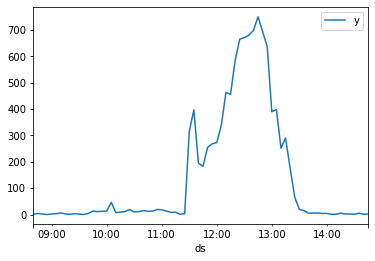

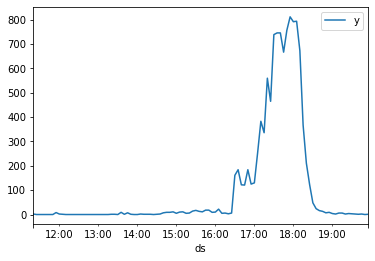

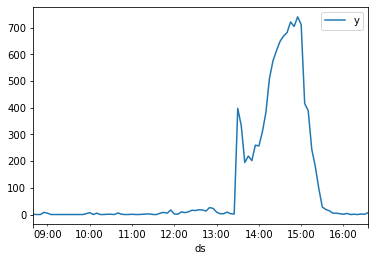

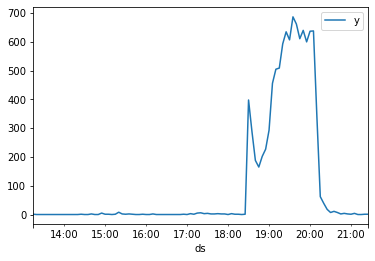

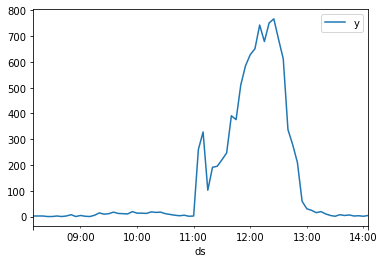

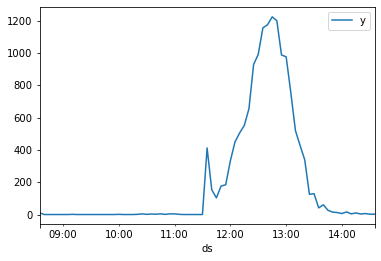

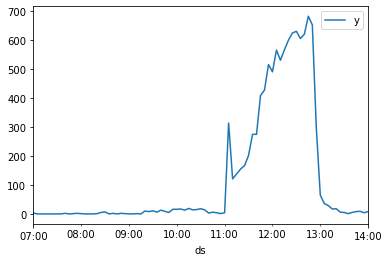

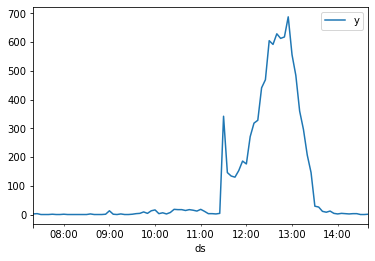

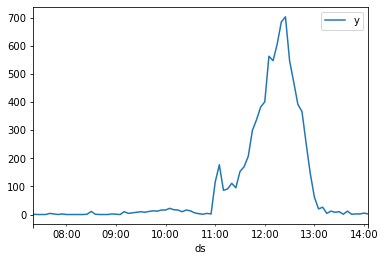

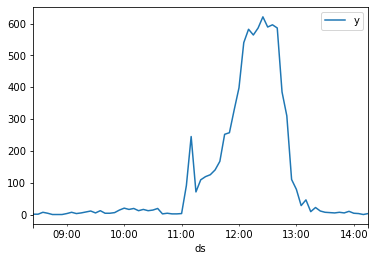

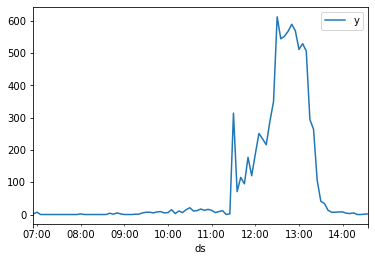

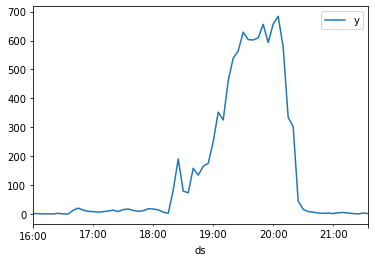

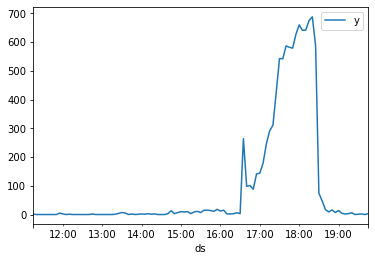

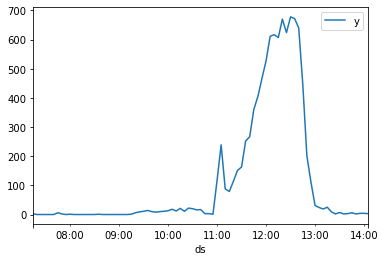

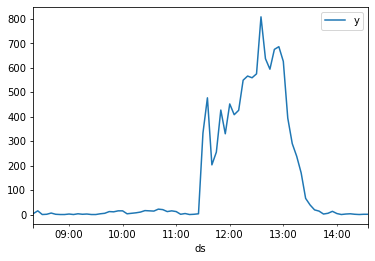

In [9]:
samples = []
for key,value in dates.items():
    game_day_start = str(key)
    game_day_end = str((pd.to_datetime(game_day_start) + pd.Timedelta("1d")).date())
    game_day = train_df.query(f"'{game_day_end}' >= ds >= '{game_day_start}'")
    game_day_sample = create_sample(df=game_day,game_day=key, start_time=value)
    game_day.set_index("ds").plot()
    plt.show()
    samples.extend(game_day_sample)


In [10]:
preprocessor = MinMaxScaler()

In [11]:
samples = np.array(samples)

In [12]:
samples = preprocessor.fit_transform(samples.reshape(-1,1))

In [13]:
samples.shape

(720, 1)

In [14]:
samples = samples.squeeze()

In [15]:
samples_test = samples[600:]
samples_train = samples[:600]

In [16]:
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [17]:
n_steps = 12
n_features = 1

In [18]:
X_train, y_train = split_sequence(sequence=samples_train,n_steps=n_steps)
X_test, y_test = split_sequence(sequence=samples_test,n_steps=n_steps)

In [19]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

In [27]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, 1),return_sequences=True))
model.add(LSTM(50, activation='relu', input_shape=(n_steps, 1),recurrent_dropout=0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [28]:
y_train.shape

(588,)

In [29]:
n_timesteps, n_features = X_train.shape[1], X_train.shape[2]

In [30]:
model.fit(X_train, y_train, epochs=200, verbose=1, validation_split=0.1)

2021-10-24 11:22:28.844942: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200
17/17 [==============================] - 5s 78ms/step - loss: 0.0513 - val_loss: 0.0291
Epoch 2/200
17/17 [==============================] - 1s 38ms/step - loss: 0.0343 - val_loss: 0.0236
Epoch 3/200
17/17 [==============================] - 1s 42ms/step - loss: 0.0295 - val_loss: 0.0189
Epoch 4/200
17/17 [==============================] - 1s 41ms/step - loss: 0.0230 - val_loss: 0.0118
Epoch 5/200
17/17 [==============================] - 1s 40ms/step - loss: 0.0137 - val_loss: 0.0053
Epoch 6/200
17/17 [==============================] - 1s 41ms/step - loss: 0.0101 - val_loss: 0.0044
Epoch 7/200
17/17 [==============================] - 1s 41ms/step - loss: 0.0088 - val_loss: 0.0037
Epoch 8/200
17/17 [==============================] - 1s 47ms/step - loss: 0.0074 - val_loss: 0.0038
Epoch 9/200
17/17 [==============================] - 1s 45ms/step - loss: 0.0066 - val_loss: 0.0034
Epoch 10/200
17/17 [==============================] - 1s 52ms/step - loss: 0.0066 - val_loss: 0.0031

In [31]:
prediction = model.predict(x=X_test)

In [32]:
prediction.shape

(108, 1)

In [37]:
preprocessor.data_max_

array([1223.])

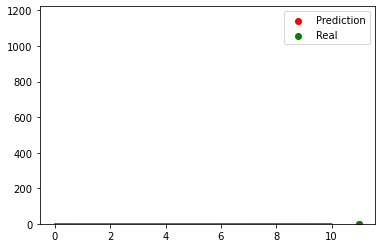

In [38]:
plt.scatter(y=prediction[0,0],x=11,color="r",label="Prediction")
plt.scatter(y=X_test[12,0,0],x=11,color="g",label="Real")
plt.plot(X_test[:11,0,0])
plt.ylim(0,1223)
plt.legend()

In [39]:
prediction.shape

(108, 1)

In [34]:
def inverse_transform(y):
    y = np.squeeze(preprocessor.inverse_transform(y.reshape(-1, 1)))
    return y

ipykernel_launcher:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


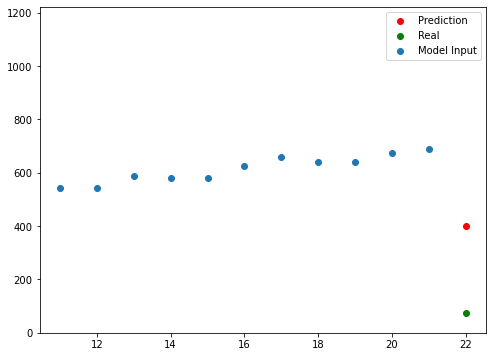

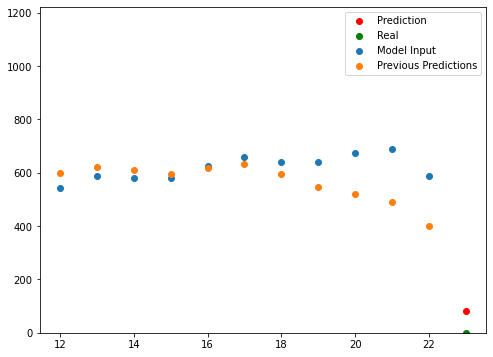

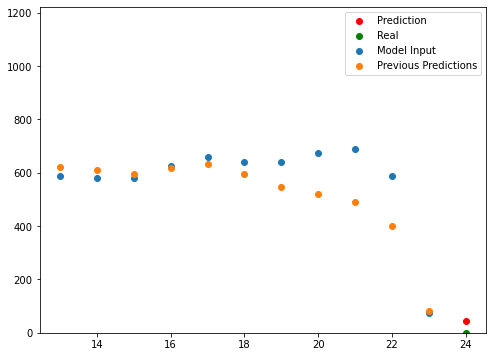

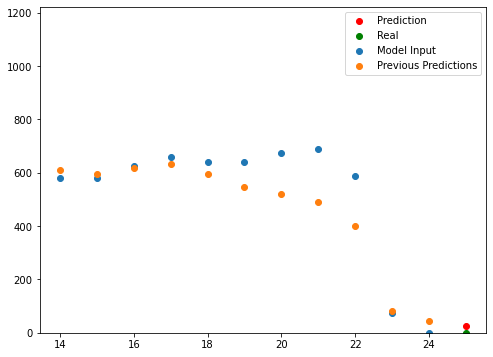

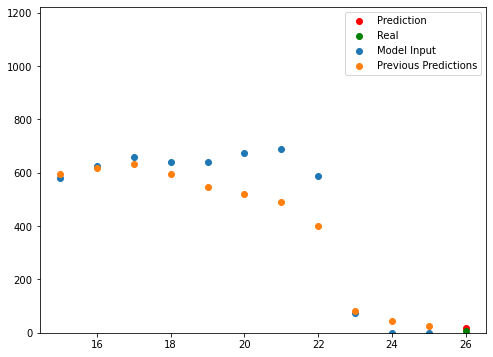

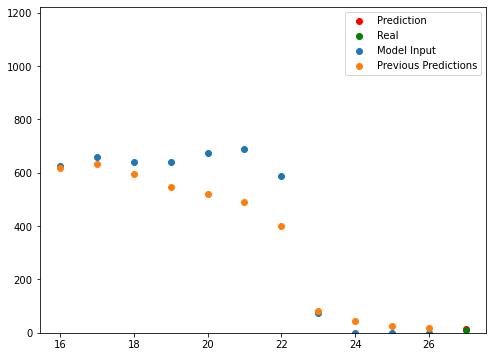

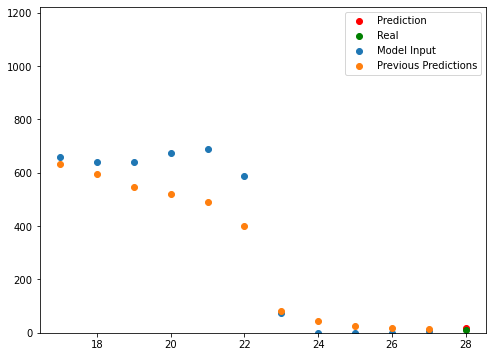

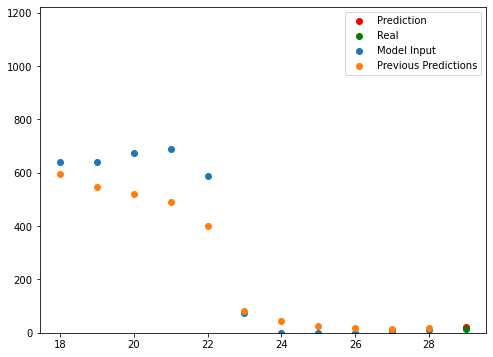

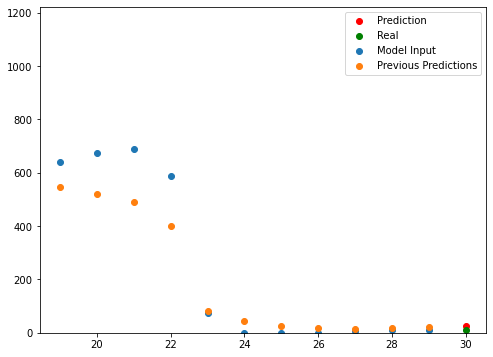

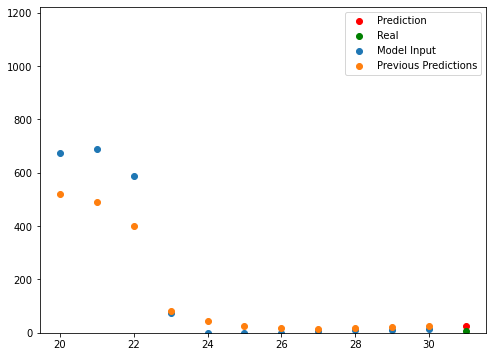

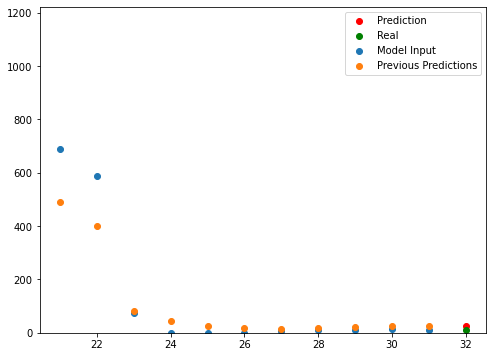

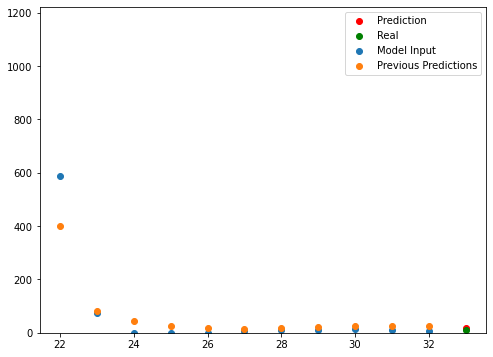

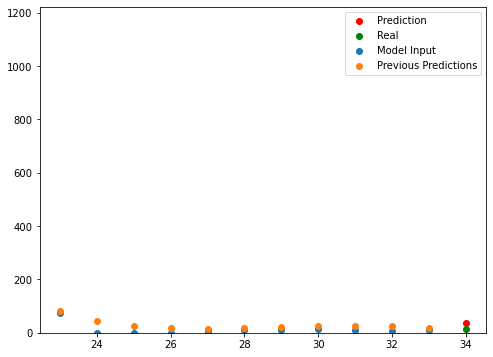

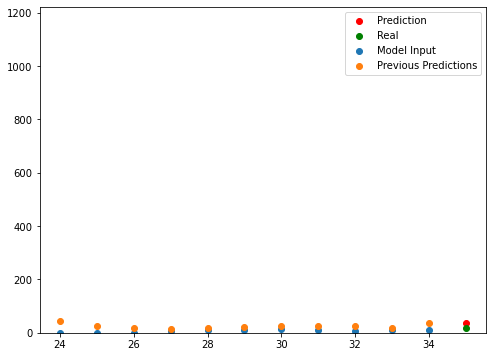

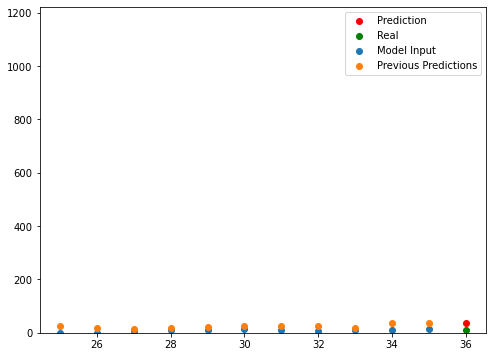

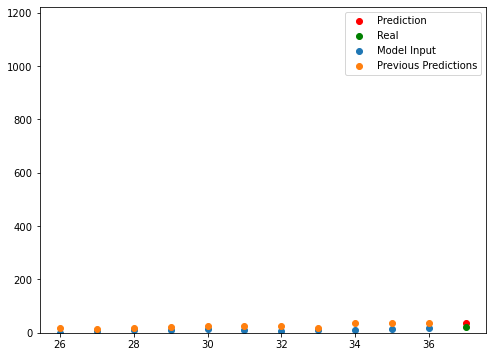

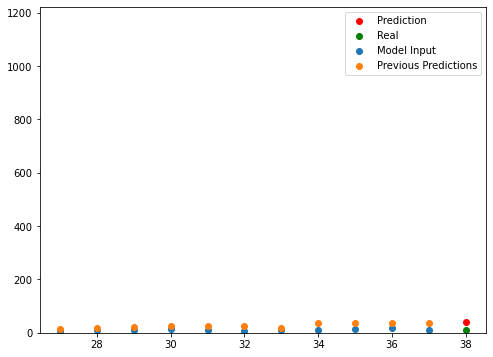

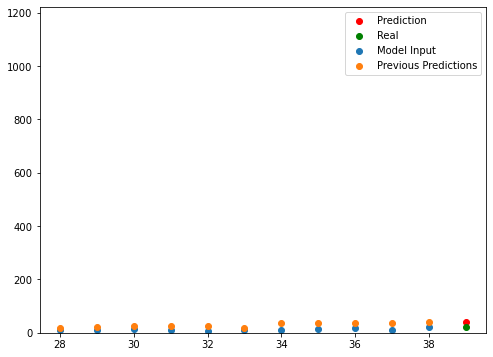

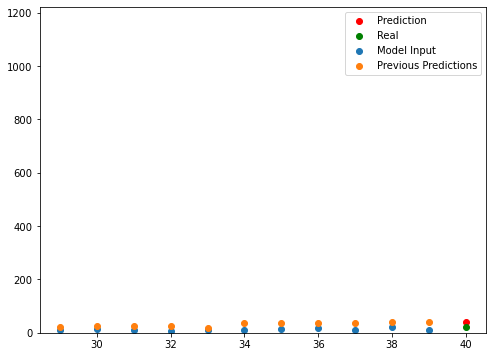

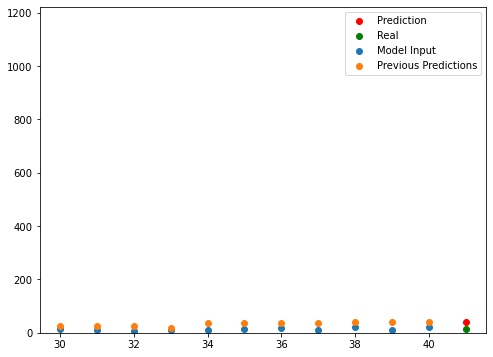

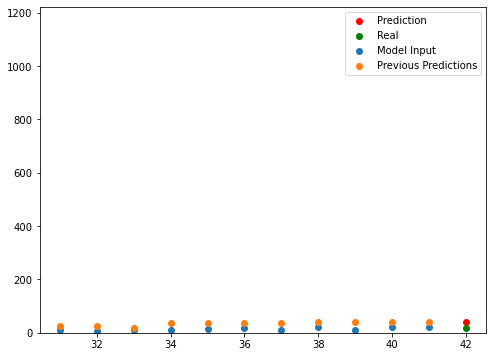

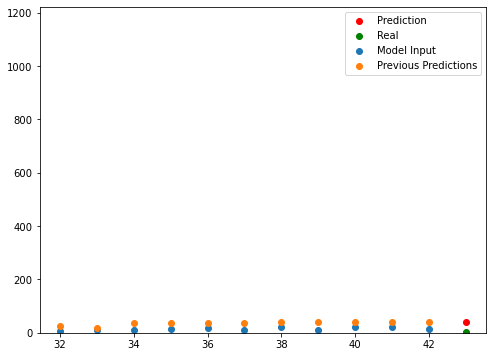

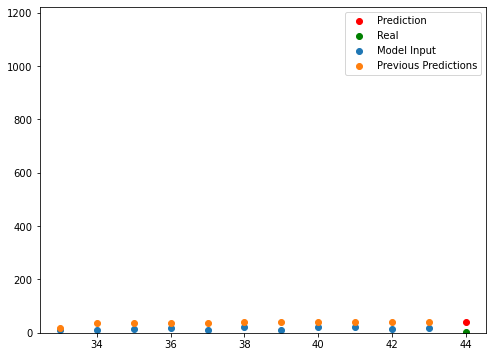

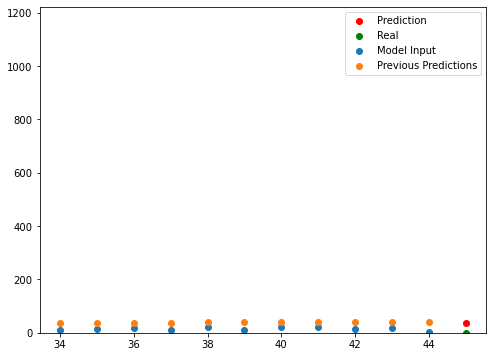

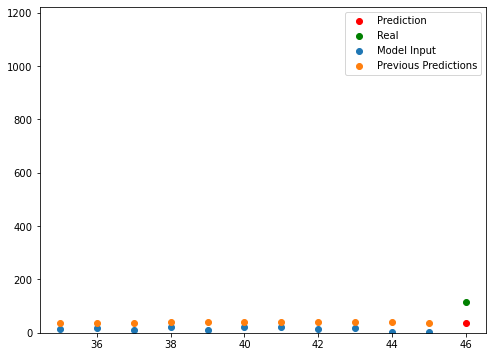

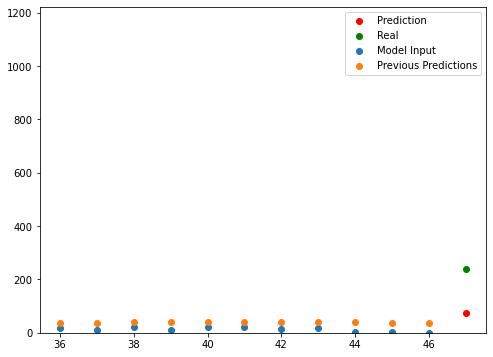

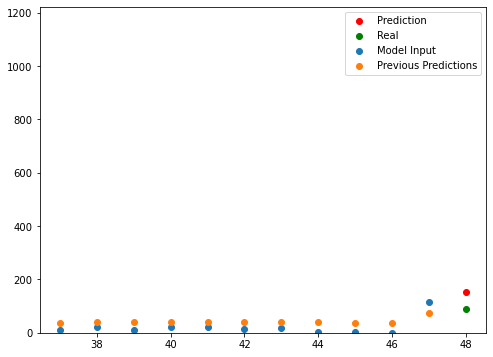

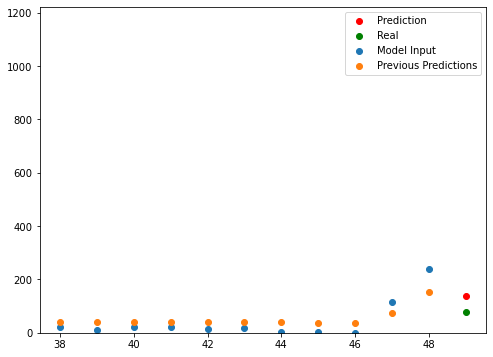

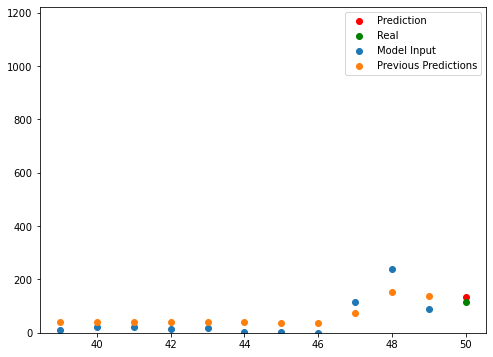

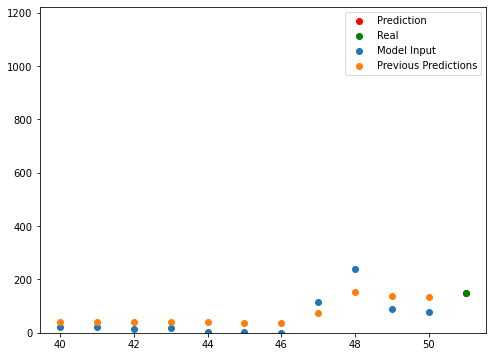

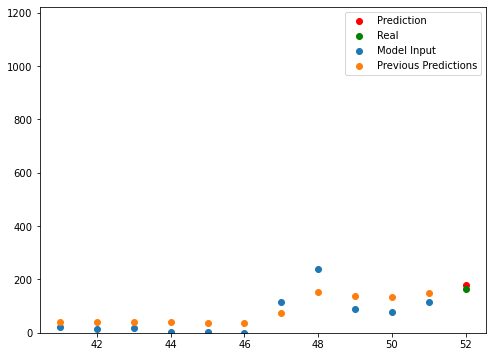

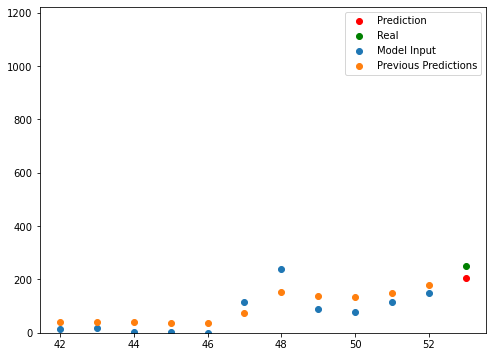

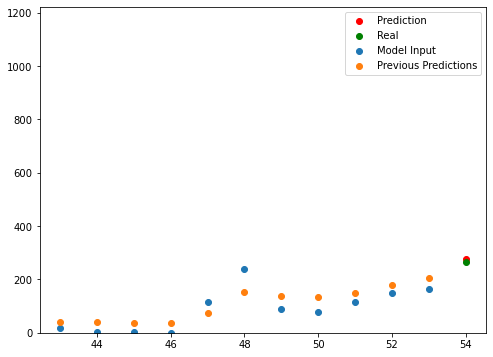

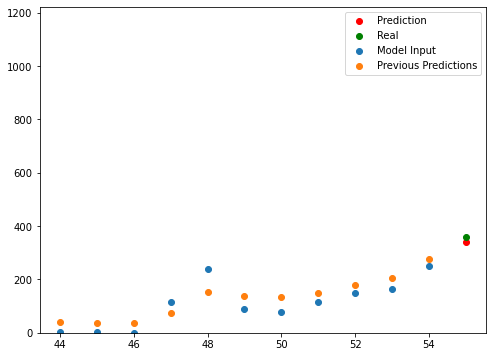

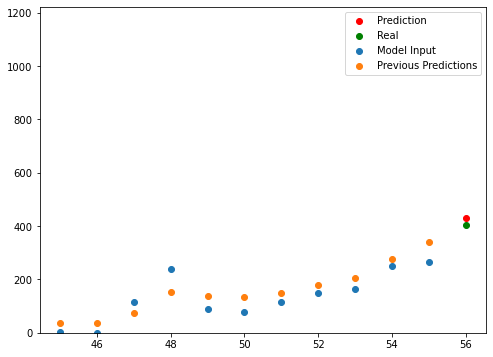

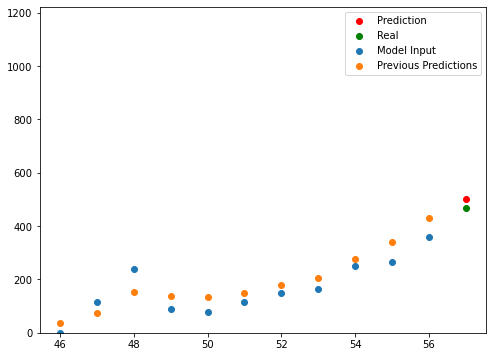

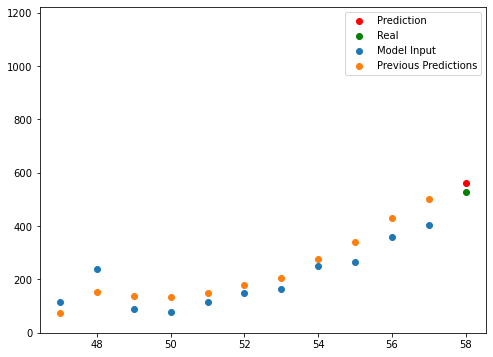

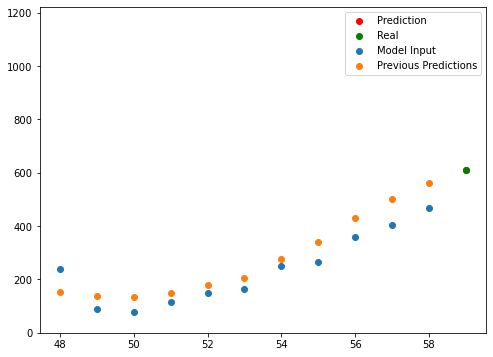

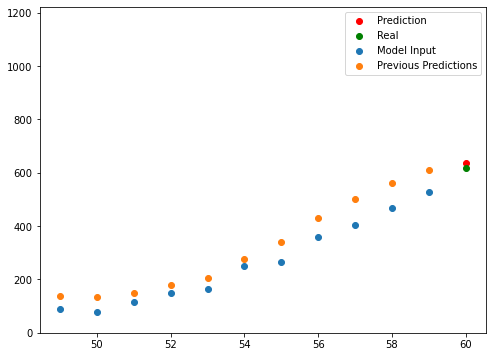

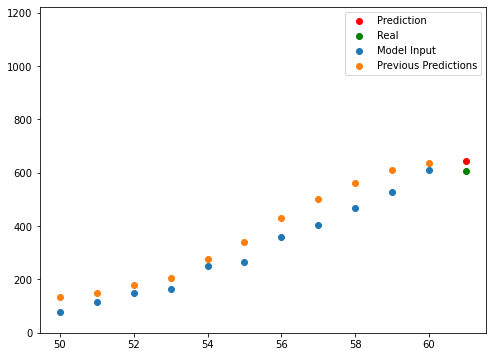

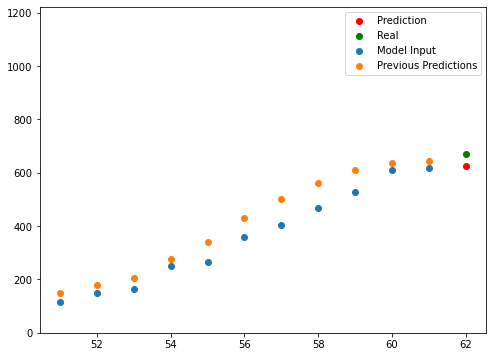

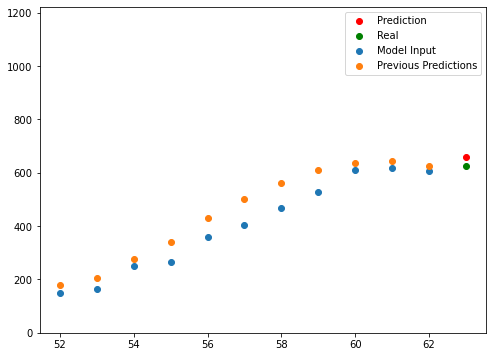

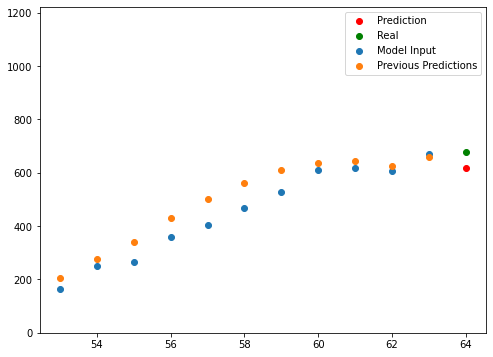

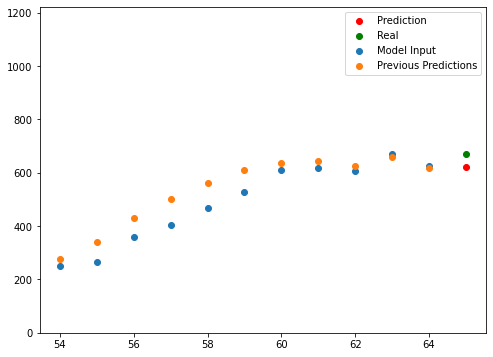

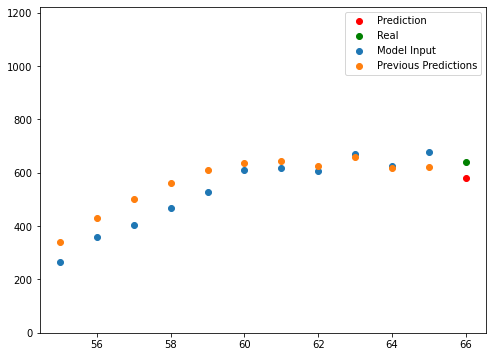

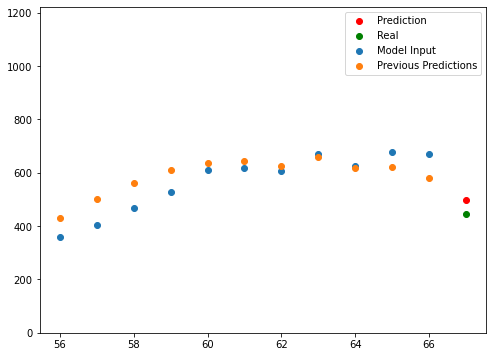

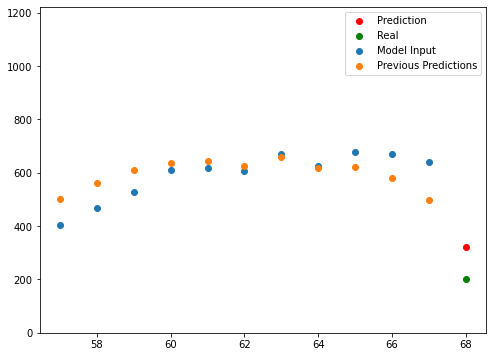

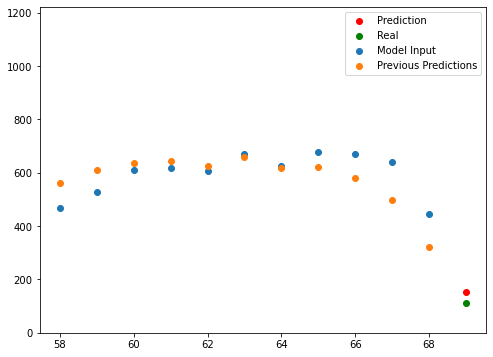

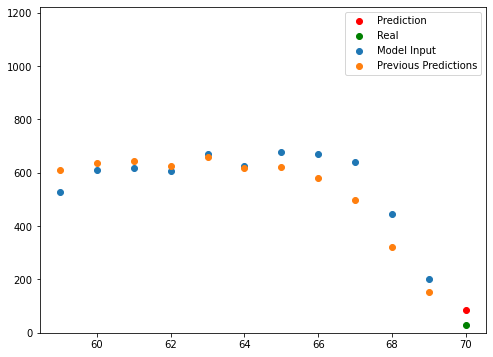

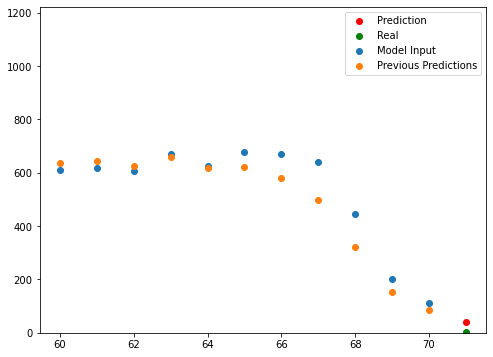

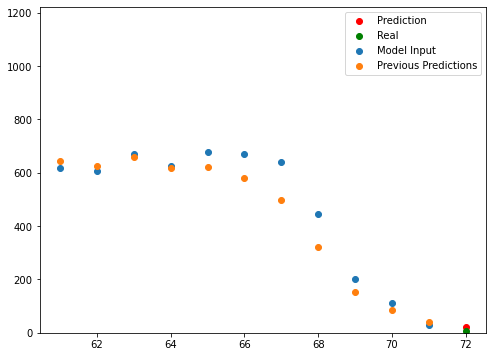

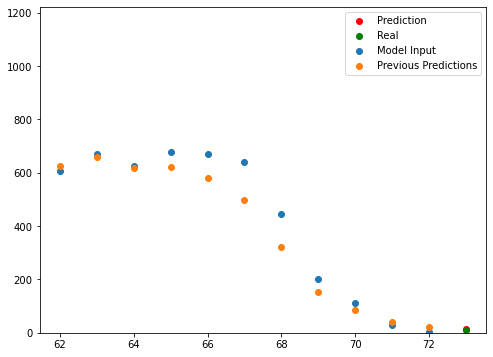

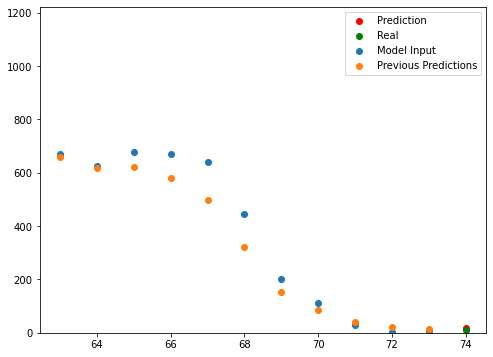

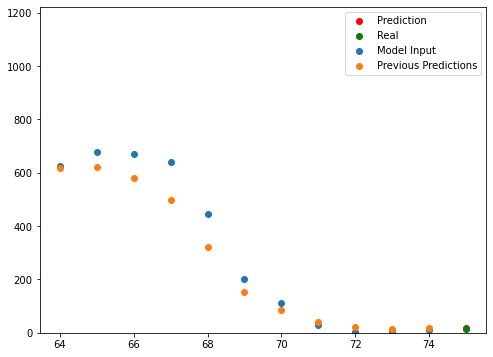

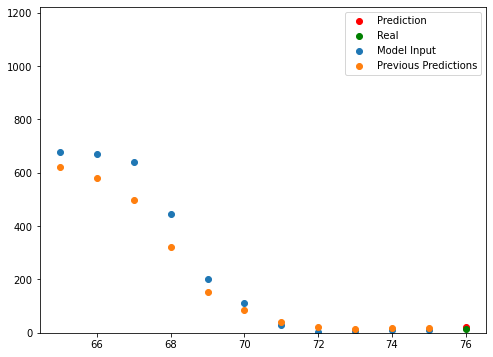

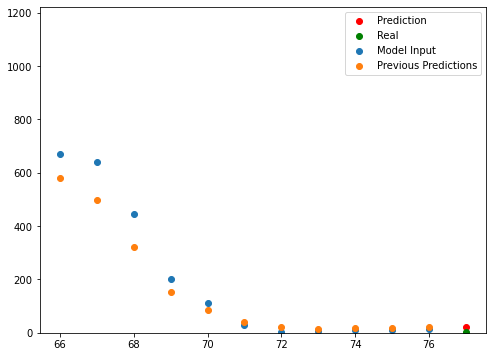

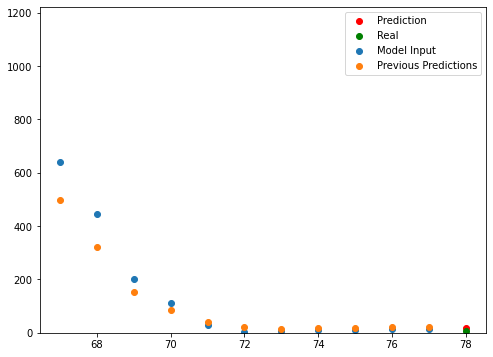

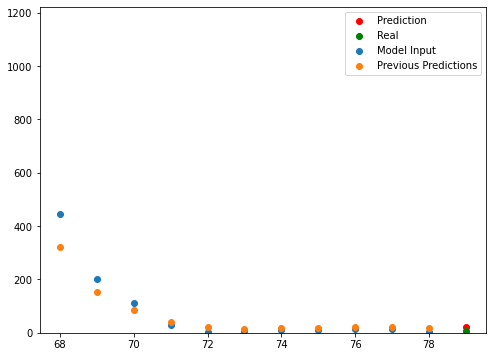

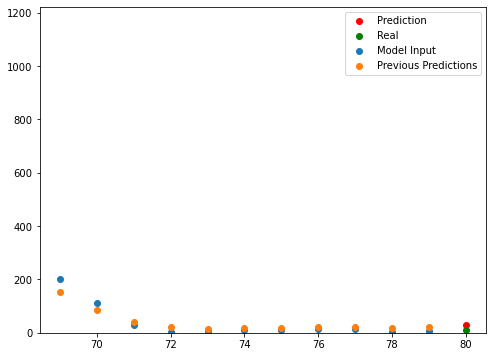

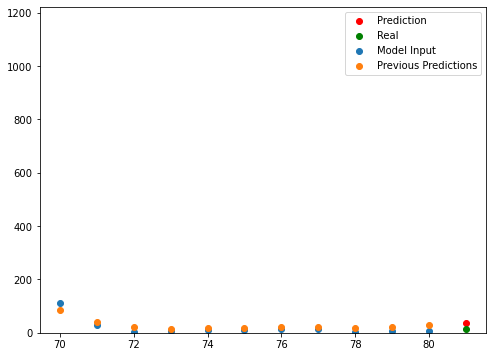

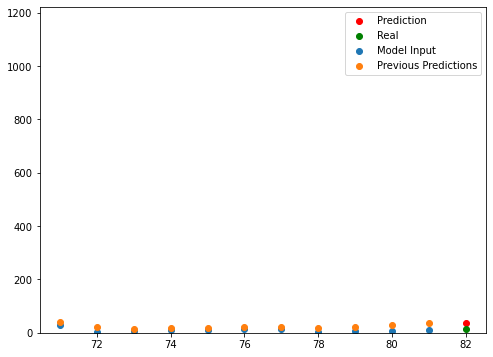

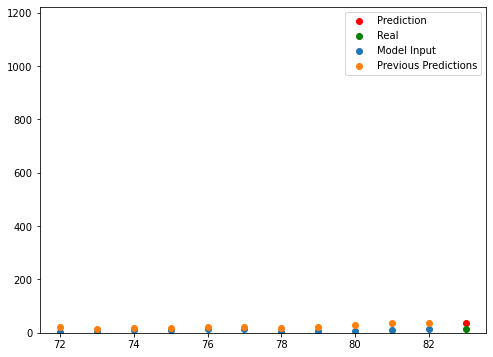

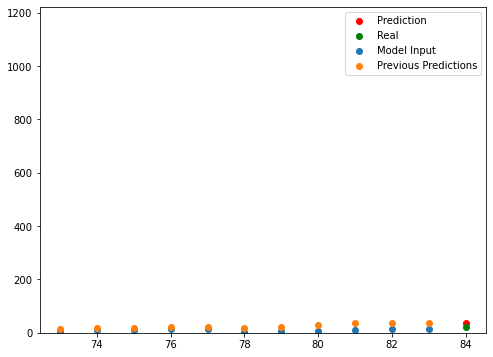

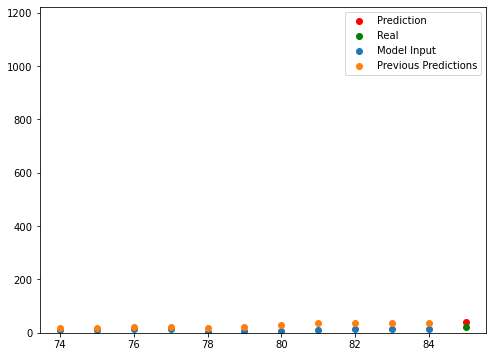

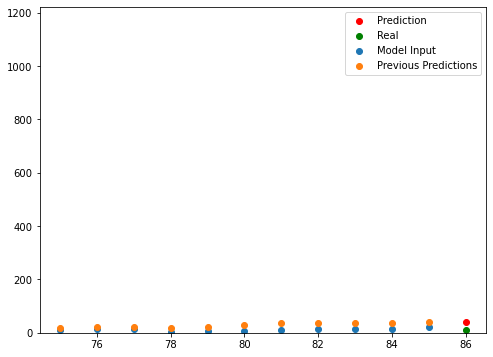

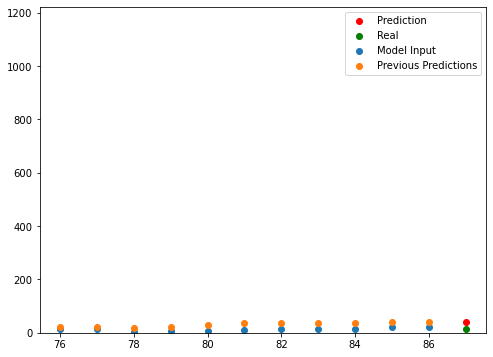

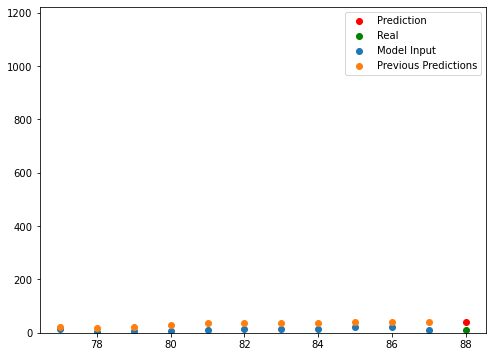

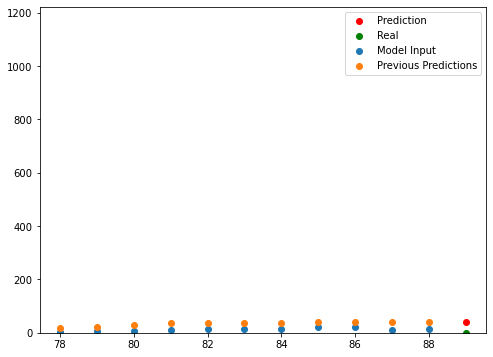

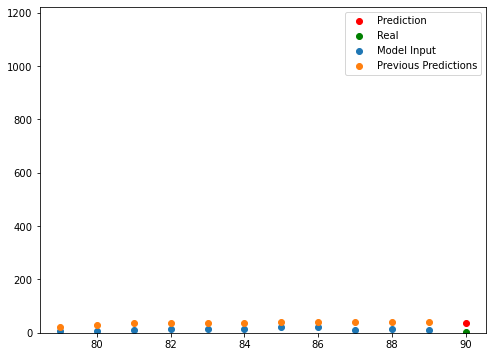

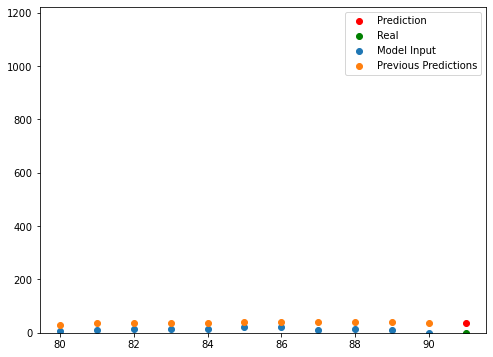

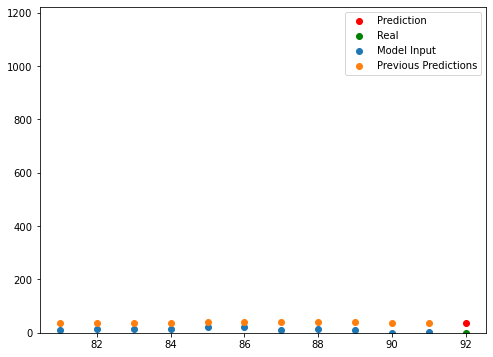

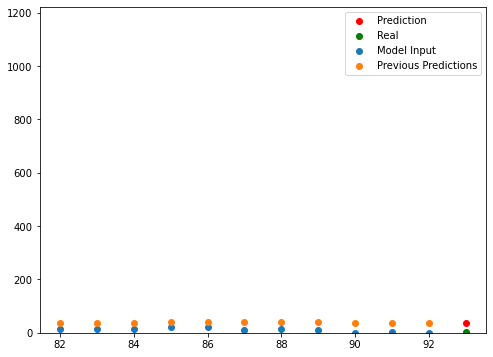

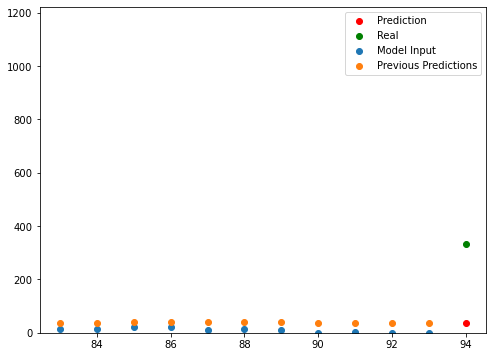

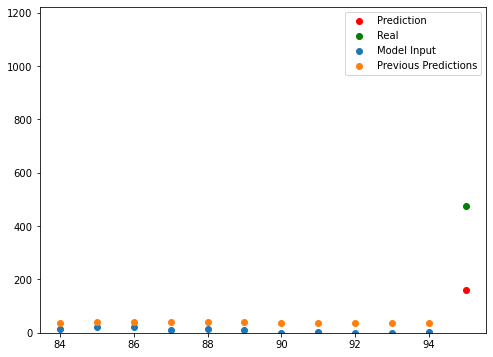

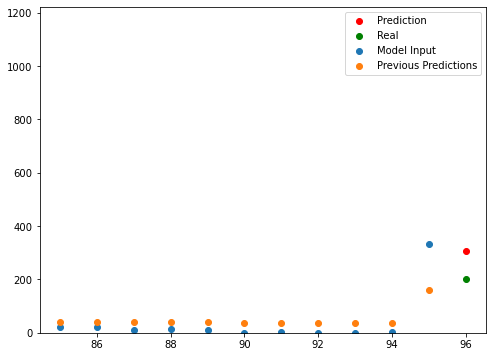

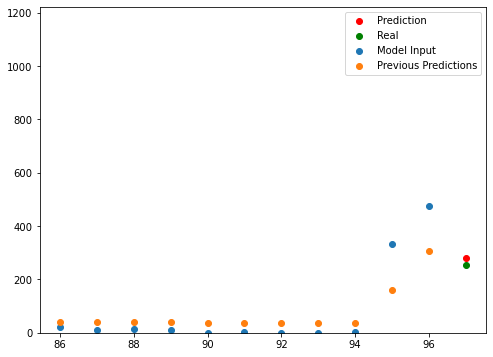

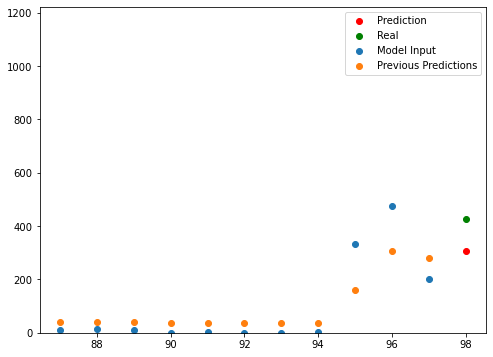

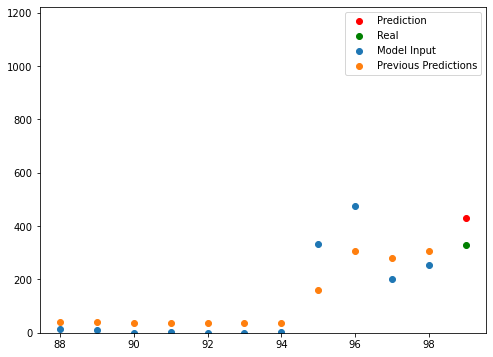

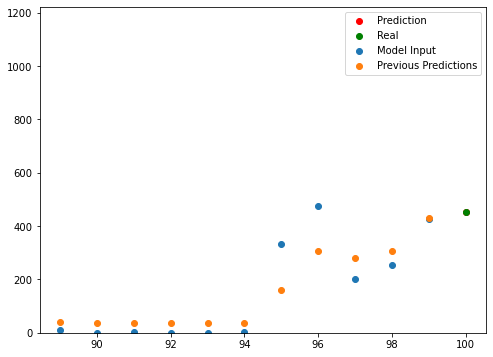

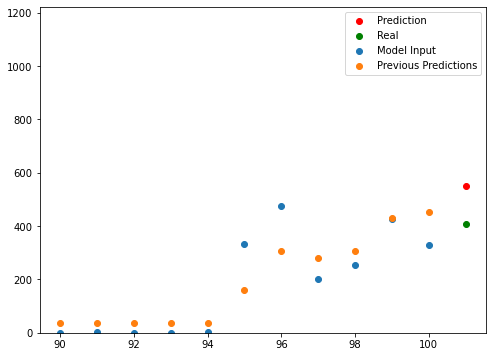

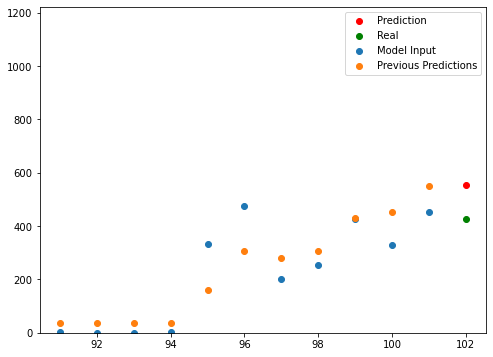

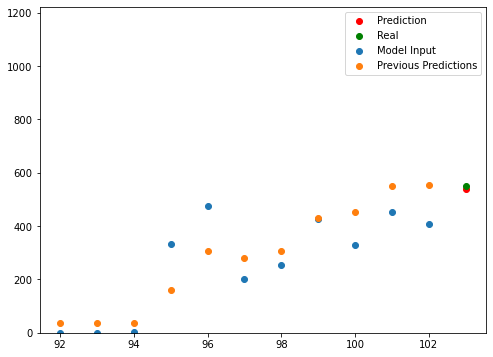

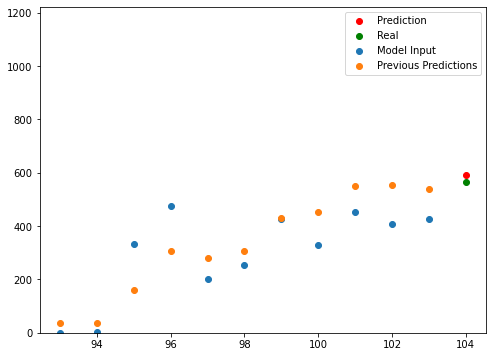

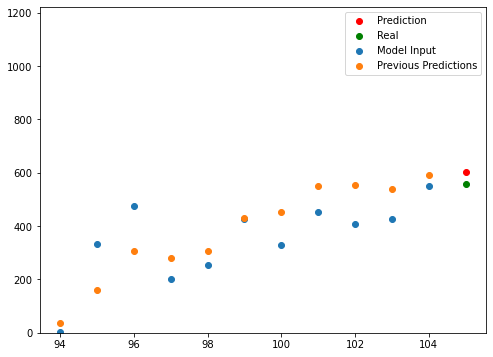

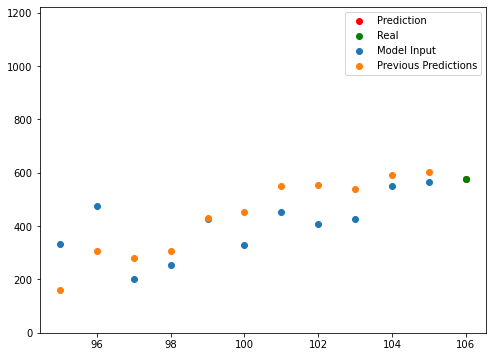

In [50]:
for i in range(11, len(prediction) -12):
    plt.figure(figsize=(8,6))
    plt.scatter(y=inverse_transform(prediction[i,0]),x=11+i,color="r",label="Prediction",marker="x",c="green")
    plt.scatter(y=inverse_transform(X_test[12+i,0,0]),x=11+i,color="g",label="Real")
    plt.scatter(y=inverse_transform(X_test[i:11+i,0,0]), x=range(i,11+i), label="Model Input")
    if i > 11:
        plt.scatter(y=inverse_transform(prediction[i-11:i,0]), x=range(i,11+i), label="Previous Predictions",,marker="x",c="yellow")
    
    plt.legend()
    plt.ylim(0,1223)
    plt.xlabel("Time Index [5min]")
    plt.ylabel("Scanned Tickets per 5min")
    #plt.show()
    plt.savefig(f"../data/interim/{i:03d}.png",dpi=300)